### Proyecto #4 - Mejora de modelo Serie de tiempo:
El principal desafío de este notebook es la extensión del modelo de serie de tiempo realizado en la entrega numero 3, realizada anteriormente. Este notebook asume la lectura del modelo de serie de tiempo realizado sobre el [dataset de trafico de AUSA (Argentina)](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa) para el año 2019, sobre la estacion ILLIA y partirá de esa base para mejorarlo y completarlo.  El principal desafío es llevar ese primer borrador de modelo básico, ya a un modelo mas terminado y profesional, con algunas correcciones pertinentes. 

#### Mejores y desafíos a resolver: 
El modelo anterior fue realizado como una primera aproximación y montado sobre arrays de numpy `crudos` realizado de manera manual, sobre los cuales montamos los atributos principales y entrenamos un primer borrador de modelo con un `RandomForest` sin ningún tipo de biblioteca, ni depuración de variables o seleccion de atributos o embebido de variables extras que pudieran ayudar a la prediccion; por lo que en este trabajo realizaremos las mejoras pertinentes en ese sentido. Además, el modelo realizamos solamente un `One-Step Prediction` es decir, tomando una cantidad de atributos predeterminada (que constaban de t-n fechas anteriores al valore a predecir) se lograba una prediccion lo mas certera posible de la fecha inmediatamente posterior, el valor objetivo, pero solo se realizaba una prediccion. En este proyecto cambiaremos eso, transformando las nuevas predicciones, a su vez, en un pronóstico extendido a `n dias futuros` de manera que sirva, de manera mucho mas a la toma de decisiones general. Por lo tanto la lista de modificaciones es la siguiente:

#### <u> Lista de Modificaciones pendientes:</u>
1. Agregaremos informacion externa al dataset, informacion categorica sobre fechas especiales con el objetivo de mejorar la prediccion.
2. Realizaremos una depuracion, dejando las variables mas relevantes para el modelo y dejando espacio para nuevos atributos
3. Implementaremos PCA y otros tipos de creacion de atributos
4. Implementaremos el modelo de manera recursiva para lograr un pronostico extendido en el tiempo con el mismo modelo

Finalmente, en las proximas secciones implementaremos un modelo similar de serie de tiempo con la bibioteca `prophet` de facebook, de manera de hacer todo este proceso mucho mas acelerado, computacionalmente eficiente, escalable, y eficiente a nivel modelado, viendo también como desempeña en comparacion con nuestro propio modelo crudo. 
______________________________

### 1.Preparacion Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle

In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [2]:
# Importado Data 
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')
# Consolidacion
dataset1 = pd.concat([data_2019, data_2018, data_2017])

In [3]:
# Filtro relevante
dataset = dataset1.query("forma_pago == 'EFECTIVO' & estacion == 'Illia'").copy()
# Defino Index; clase DateTime para Serie de tiempo
dataset.index = pd.to_datetime(dataset.fecha)
dataset = dataset.resample("D").sum().copy()

In [4]:
# Feriados; importo feriados sacados manualmente de Gobierno (innecesario hacer scrapping)
feriados17=['2017-01-01','2017-02-27','2017-02-28','2017-03-28','2017-04-02','2017-04-13','2017-04-14','2017-05-01','2017-06-17','2017-06-20','2017-07-09','2017-08-17','2017-10-12','2017-11-20','2017-12-08','2017-12-25']
feriados18=['2018-01-01','2018-02-12','2018-02-13','2018-03-24','2018-03-30','2018-04-02','2018-04-30','2018-05-01','2018-05-25','2018-06-17','2018-06-20','2018-07-09','2018-08-20','2018-10-15','2018-11-19','2018-12-08','2018-12-24','2018-12-25','2018-12-31']
feriados19=['2019-01-01','2019-03-04','2019-03-05','2019-03-24','2019-04-02','2019-04-18','2019-04-19','2019-05-01','2019-05-25','2019-06-17','2019-06-20','2019-07-08','2019-07-09','2019-08-17','2019-08-19','2019-10-12','2019-10-14','2019-11-18','2019-12-08','2019-12-25']

feriados = feriados17 + feriados18 + feriados19

### 2. Creacion de nuevas variables

In [5]:
# Creamos columna con info de feriados
dataset['fl_feriado'] = dataset.index.isin(feriados)
# casteo forzado a int, en caso que algun algoritmo en C/C++ no reconozca booleano
dataset.fl_feriado = dataset.fl_feriado.astype(int) 
dataset.drop(columns=['hora_inicio', 'hora_fin', 'periodo'], inplace=True)

In [6]:
# Creamos variables de dia de semana
dataset['dia'] = dataset.index.weekday.astype(int)

Aca podemos ver el resultado de las nuevas variables encodeadas; tanto `fl_feriado` y `dia`

In [7]:
dataset.head()

,cantidad_pasos,fl_feriado,dia
fecha,,,
2017-01-01,31183,1,6
2017-01-02,51568,0,0
2017-01-03,51093,0,1
2017-01-04,53332,0,2
2017-01-05,56486,0,3


Sin embargo necesitamos al dia tambien en formato dummie, lo transformamos con `pd.get_dummies(...)` y ya estamos listos para proceder con las nuevas variables y limpieza y seleccion de atributos:

In [8]:
# Creamos dummies para semana
dataset= pd.get_dummies(dataset, columns=['dia'] , prefix='dia')
dataset

,cantidad_pasos,fl_feriado,dia_0,dia_1,dia_2,dia_3,dia_4,dia_5,dia_6
fecha,,,,,,,,,
2017-01-01,31183,1,0,0,0,0,0,0,1
2017-01-02,51568,0,1,0,0,0,0,0,0
2017-01-03,51093,0,0,1,0,0,0,0,0
2017-01-04,53332,0,0,0,1,0,0,0,0
2017-01-05,56486,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
2019-12-27,40182,0,0,0,0,0,1,0,0
2019-12-28,30681,0,0,0,0,0,0,1,0
2019-12-29,26259,0,0,0,0,0,0,0,1


### 3. Exploracion y reduccion de atributos anteriores

Segun lo que vimos en el modelo anterior, ciertos atributos (siempre `fechas`) eran mucho mas importantes que otros. Con un poco de limpieza e ingeniería de atriutos podemos empezar a encontrar ciertas mejoras que explotar, para hacer el modelo mas reducido, interpretable y preciso.   

Esto es lo que haremos ahora. Para comenzar, tengamos en cuenta que en el ultimo modelo encontramos el siguiente TOP 10 de atributos `t-n` mas importantes :

In [9]:
file = 'serie_tiempo_py3.sav'; modelo_cargado = pickle.load(open(file, 'rb'))
atributos = pd.DataFrame({'peso':modelo_cargado.feature_importances_, 't-n':[x-180 for x in range(len(modelo_cargado.feature_importances_))]})
atributos.sort_values(by='peso', ascending=False).head(10)

,peso,t-n
173,0.427662,-7
159,0.041679,-21
179,0.039732,-1
166,0.028208,-14
26,0.027606,-154
33,0.020211,-147
152,0.018102,-28
124,0.016876,-56
82,0.010604,-98
54,0.010600,-126


Si importamos `StatsModels` y analizamos el correlograma validamos parte de este comportamiento. Hay un comportamiento recursivo sobre los 7 dias, la observacion `t-7` y la observacion inmediatamente anterior `t-1` estás fuertemente correlacionada con la fecha en curso. Luego este movimiento sigue de manera recursiva en el tiempo.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


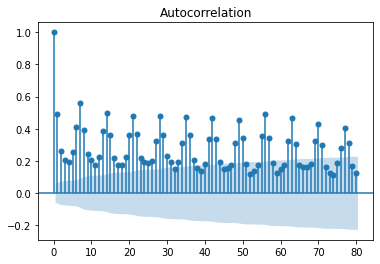

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
a = plot_acf(dataset.cantidad_pasos.values, lags = 80, alpha=.05)
a.figsize=(20,3)

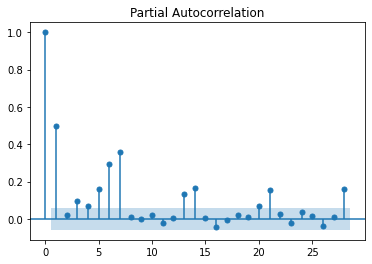

In [11]:
a = plot_pacf(dataset.cantidad_pasos.values, lags = 28, alpha=.05)


Esto confirma en principio lo que vimos anteriormente. 

> Resultados: 
1. Que la serie está altamente correlacionada estacionalmente consigo misma, de manera positiva y significativa (por encima de un Intervalo de confianza del 95%), hasta pasados los 80 dias.
2. Que las correlaciones mas altas se dan en periodos de 7 dias, y sus margenes.
3. La Correlacion Parcial parece sugerir un proceso autorregresivo funcion de 7 dias hacia el pasado. 

#### Seleccion de Atributos Finales
Por lo que procedemos a limpiar y arreglar nuestras nuevas variables. Vamos a tomar las 5 mejores variables identiicadas pro el modelo anterior, al momento, por ahora estas son:

1. `t-7`
2. `t-21`
3. `t-1`
4. `t-14`
5. `t-154`

A esta lista vamos a agregar el marcador encodeado de observacion atípica por `feriado_nacional` y tambien un indicador de `dia_semana` para ver cual es su impacto, y el de los fines de semana, en el modelado, más alla del lag -7 de los valores a ciegas. Luego lo plasmaremos en un Array de 7 columnas, y del mismo largo que el modelo anterior para poder predecir y comparar contra la misma serie  

6. `fl_feriado`
7. `fl_dia_semana`


Text(0.5, 1.0, 'Limpieza de Outliers - Serie Cruda')

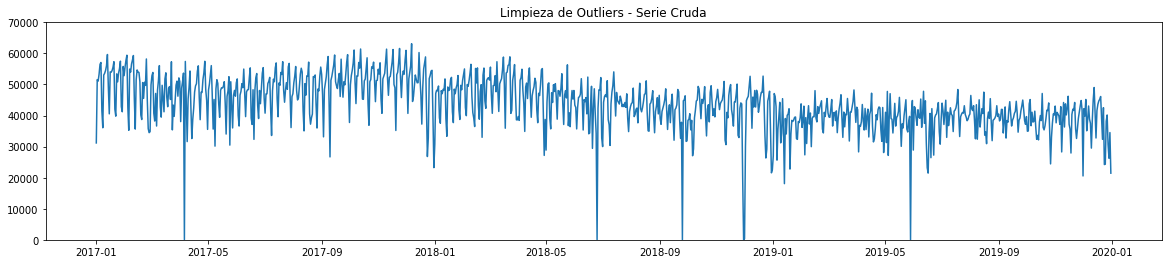

In [12]:
plt.figure(figsize=(20,4)); plt.plot(dataset.cantidad_pasos); plt.ylim((0,70000))
plt.title("Limpieza de Outliers - Serie Cruda")


#### Limpieza de Outliers - No feriados  
Analizamos los outliers de manera clásica, sin ventanas moviles, ni dinamicos, aplicamos criterio estático para definir outliers de la serie por ahora y compararlo con los feriados:

In [13]:
from sklearn.preprocessing import StandardScaler as sc
res = sc().fit_transform(dataset.cantidad_pasos.to_numpy().reshape(-1,1))
filtro = (res > 3) | (res <-3)
dataset[filtro]

,cantidad_pasos,fl_feriado,dia_0,dia_1,dia_2,dia_3,dia_4,dia_5,dia_6
fecha,,,,,,,,,
2017-04-06,40,0,0,0,0,1,0,0,0
2018-06-25,0,0,1,0,0,0,0,0,0
2018-09-25,0,0,0,1,0,0,0,0,0
2018-11-30,0,0,0,0,0,0,1,0,0
2018-12-01,350,0,0,0,0,0,0,1,0
2019-01-13,18076,0,0,0,0,0,0,0,1
2019-05-29,0,0,0,0,1,0,0,0,0


Como podemos ver en la siguiente celda, los resultados de outliers no son causados particularmente por feriados sino cargas erroneas o faltantes, por lo cual lo imputaremos interpolando como en el trabajo anterior: 

In [14]:
dataset[filtro].index.isin(feriados)

array([False, False, False, False, False, False, False])

Text(0.5, 1.0, 'Limpieza de Outliers - Serie Interpolada')

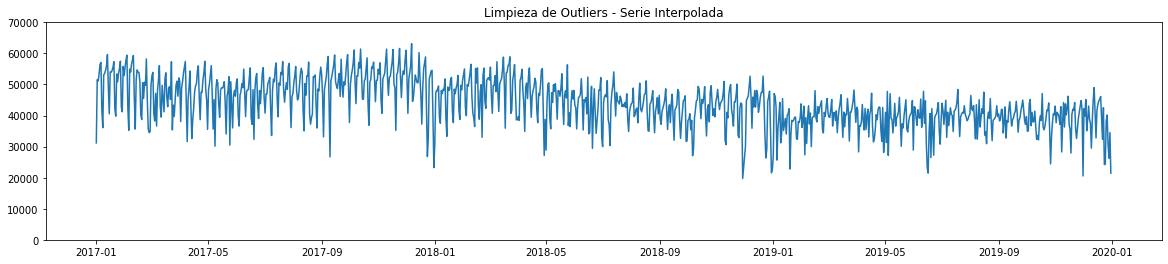

In [15]:
# Relleno con las diferentes metodologías
dataset.loc[filtro.flatten(),'cantidad_pasos'] = np.nan
dataset['cantidad_pasos'] = dataset.cantidad_pasos.interpolate().values
plt.figure(figsize=(20,4)); plt.plot(dataset.cantidad_pasos); plt.ylim((0,70000))
plt.title("Limpieza de Outliers - Serie Interpolada")

#### Creacion de estructuras y filtrado de variables relevantes  
Extraigo y filtro variables destacadas del trabajo anterior y nuevas seleccionadas; fechas relevantes, marcas de feriados y de tipo de dia de la semana

In [16]:
lookback = 180 # mismo lookback modelo original para compatibiliad y comparacion de series
X = np.zeros((dataset.shape[0]-lookback, 8+5)) # Columnas: 8 categoricas + 5 lags
y = np.zeros((dataset.shape[0] -lookback,)) 
n = X.shape[0]

In [17]:
for i in range(n):
    # Agarrar -1, -7, -14, -21, -154
    X[i,:] = (dataset.fl_feriado.iloc[lookback+i],# marca feriado
    dataset.dia_0.iloc[lookback+i],# marca semana 
    dataset.dia_1.iloc[lookback+i],
    dataset.dia_2.iloc[lookback+i],
    dataset.dia_3.iloc[lookback+i],
    dataset.dia_4.iloc[lookback+i],
    dataset.dia_5.iloc[lookback+i],
    dataset.dia_6.iloc[lookback+i],
    dataset.cantidad_pasos.iloc[lookback-1+i],
    dataset.cantidad_pasos.iloc[lookback-7+i],
    dataset.cantidad_pasos.iloc[lookback-14+i],
    dataset.cantidad_pasos.iloc[lookback-21+i],
    dataset.cantidad_pasos.iloc[lookback-154+i])  # Composicion de Serie
    y[i] = dataset.cantidad_pasos.iloc[lookback+i] # Composicion y objetivo

X_df = pd.DataFrame(X).rename(columns={x:f'dia_{str(x)}'for x in range(1,8)}).rename(columns={0:'fl_feriado', 8:'t-1', 9:'t-7',10:'t-14', 11:'t-21', 12:'t-154'})
col_names = X_df.columns

Voy a separar las variables dummies de las demas para extraer nuevas relaciones polinomicas y escalar

In [18]:
atrs = X[:,-5:]; display(atrs)
dummies = X[:,:-5]; display(dummies)

array([[53626., 53526., 55347., 54965., 57506.],
       [55433., 43183., 39192., 46901., 42831.],
       [45628., 39042., 37147., 39656., 41218.],
       ...,
       [30681., 32337., 32774., 38839., 39500.],
       [26259., 42531., 41588., 37518., 38338.],
       [34523., 24220., 43597., 29518., 38817.]])

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

#### Creacion de relaciones polinomicas   

In [19]:
#Creo atributos polinomicos para detectar nuevas relaciones potenciales
from sklearn.preprocessing import PolynomialFeatures

poly=PolynomialFeatures(degree=4, include_bias=False)

poly_atrs = poly.fit_transform(atrs); 
poly_cols = poly.get_feature_names()

# Escalamos los datos para no distorsionar la variabilidad de PCA por las escalas de cada variable
from sklearn.preprocessing import StandardScaler

scaled_poly = StandardScaler().fit_transform(poly_atrs)

#### Descomposicion PCA - Seleccion de Componentes Principales 
Realizamos descomposicion PCA para seleccionar atributos y descartar relaciones polinomicas y variables no representativas de variabilidad. 

In [20]:
from sklearn.decomposition import PCA
X_pca = np.concatenate((dummies, scaled_poly), axis =1)
pca = PCA(n_components=X.shape[1], random_state=1)
X_pca = pca.fit_transform(X) 

pca.explained_variance_

array([1.72760638e+08, 3.46628893e+07, 2.72946856e+07, 2.11555183e+07,
       1.77074883e+07, 1.44063685e-01, 1.43325529e-01, 1.42751690e-01,
       1.42260302e-01, 1.11493688e-01, 8.04694887e-02, 4.43987176e-02,
       1.48480919e-27])

In [21]:
# Descarto primeros 10 componentes principales, poco explicativos
X = X_pca[:,:-5]
pd.DataFrame(X).tail()

,0,1,2,3,4,5,6,7
910,-855.791150,3845.629671,3799.632812,-6326.229531,-4496.858358,-0.109766,-0.429324,0.589363
911,-6486.899596,468.344646,1923.881713,2407.193881,804.605142,0.535282,0.117543,-0.007852
912,-19416.655713,6397.799800,-1376.704053,3825.905201,2058.960122,-0.509867,-0.317893,0.086980
913,-13325.256378,11120.825584,5826.371780,-5627.405451,163.676686,0.570738,-0.180051,-0.002967
914,-21285.137470,2174.911350,-1089.641527,3055.667218,-14162.378582,-0.214085,0.816570,0.344583


<u>**Nota:**</u> _Si bien lo estamos intentando, hay que destacar que las relaciones polinomiales + PCA probablemente no hayan sumado mucho, ya que al trabajar series de tiempo y elegir principalmente atributos fuertemente autocorrelacionados, en el orden de los 7 dias, y si la mayoria de nuestros atributos son observaciones con alta autocorrelacion, la variabilidad de esos atributos probablemnte siempre vayan en la misma direccion. Si este es el caso, esta acción no agregaría nueva informacion y no mejoraría demasiado el modelo. Por lo cual, el PCA, en este caso, solo ayuda a la reduccion final del dataset y a descartar redundancias y relaciones polinomiales poco explicativas; sin aportar demasiado. Habria que analizar que sucederia si realizamos lo mismo con el dataset original completo con todas sus fechas, para descubrir nuevas relaciones._

#### Nuevo Modelo - RandomForest mejorado 

In [22]:
X

array([[ 2.54423697e+04,  1.69180353e+02, -1.90116405e+03, ...,
        -1.02139974e-01, -4.29194368e-01,  5.92285925e-01],
       [ 3.53450708e+03, -1.13850363e+04, -1.91733343e+03, ...,
         5.46672476e-01,  1.17711525e-01, -5.21734144e-03],
       [-7.25843096e+03, -5.21379674e+03, -2.41881680e+03, ...,
        -4.97494063e-01, -3.17822375e-01,  8.65632120e-02],
       ...,
       [-1.94166557e+04,  6.39779980e+03, -1.37670405e+03, ...,
        -5.09867406e-01, -3.17892677e-01,  8.69801968e-02],
       [-1.33252564e+04,  1.11208256e+04,  5.82637178e+03, ...,
         5.70737513e-01, -1.80051390e-01, -2.96679442e-03],
       [-2.12851375e+04,  2.17491135e+03, -1.08964153e+03, ...,
        -2.14084511e-01,  8.16569984e-01,  3.44583370e-01]])

In [46]:
from sklearn.ensemble import RandomForestRegressor
model_object = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = -1)


def ts_cv(df, model_object, n_splits=4, figsize=(20,4)):

    from sklearn.metrics import mean_squared_error # para RSME
    from sklearn.model_selection import TimeSeriesSplit # para Indices

    errores = []
    dd = {}

    tss = TimeSeriesSplit(n_splits=n_splits)
    md = model_object

    # devuelve array de numpy
    if isinstance(df, pd.DataFrame):
        X = pd.to_numpy(df)
    elif isinstance(df, np.ndarray):
        X = df
    # Tamaño graficado
    plt.figure(figsize=figsize)
    plt.title(f"Importancias Atributos - Splits:")

    # Crea indices para cortes de Serie de tiempo
    for ix, data_index in enumerate(tss.split(X)):
        train_index, test_index = data_index

        # Muestra Numero de Split + Fronteras de corte
        print(f"TRAIN # {ix}:", train_index.shape, "TEST:", test_index.shape)
        X_train, X_test = X[train_index], X[test_index]    
        y_train, y_test = y[train_index], y[test_index]

        # Ajusto modelo sobre corte
        md = model_object.fit(X_train,y_train)

        # Prediccion y medicion de errores
        y_test_pred = md.predict(X_test)
        error_split = np.sqrt(mean_squared_error(y_test, y_test_pred))
        errores.append(error_split)

        # Comparacion contra Benchmark (dia anterior):
        benchmark =  y[test_index - 1] # un dia menos para todos los indices
        error_benchmark = np.sqrt(mean_squared_error(y_test, benchmark))

        # Guardo importancias en Dataframes para explorar
        dd[f'Importancias_split_{ix}'] = pd.DataFrame({'IMPORTANCIA':md.feature_importances_ , 'error':error_split})
        dd[f'Errores_split_{ix}'] = error_split

        # Graficado - Feature importances de cada Split
        sns.scatterplot(x=np.arange(md.feature_importances_.size), y=md.feature_importances_, alpha = 0.6, label=f"Split # {ix+1}", s=90)
        plt.xlabel("Atributos"); plt.ylabel("Score - Importancia")

        # Impresion resultados
        print(f"    --> Error Modelo: RMSE: {error_split}")
        print(f"    --> Error Benchmark - Dia anterior: {error_benchmark}")
        print(f"    --> Diferencia = Modelo - Bench : {error_split-error_benchmark}")

    print("\n\n", f"CROSS VALIDATION SCORE: {np.mean(errores)}")
    dd[f'CV_SCORE']=np.mean(errores)

    return dd

TRAIN # 0: (155,) TEST: (152,)
    --> Error Modelo: RMSE: 5245.046247480682
    --> Error Benchmark - Dia anterior: 8039.626963802814
    --> Diferencia = Modelo - Bench : -2794.5807163221325
TRAIN # 1: (307,) TEST: (152,)
    --> Error Modelo: RMSE: 4622.822150597683
    --> Error Benchmark - Dia anterior: 6436.516032107661
    --> Diferencia = Modelo - Bench : -1813.6938815099784
TRAIN # 2: (459,) TEST: (152,)
    --> Error Modelo: RMSE: 5860.167736372615
    --> Error Benchmark - Dia anterior: 6904.859748851948
    --> Diferencia = Modelo - Bench : -1044.6920124793332
TRAIN # 3: (611,) TEST: (152,)
    --> Error Modelo: RMSE: 4796.100374262613
    --> Error Benchmark - Dia anterior: 6459.9680332128255
    --> Diferencia = Modelo - Bench : -1663.867658950213
TRAIN # 4: (763,) TEST: (152,)
    --> Error Modelo: RMSE: 4489.926791098749
    --> Error Benchmark - Dia anterior: 6239.3188488302485
    --> Diferencia = Modelo - Bench : -1749.3920577314993


 CROSS VALIDATION SCORE: 5002.81

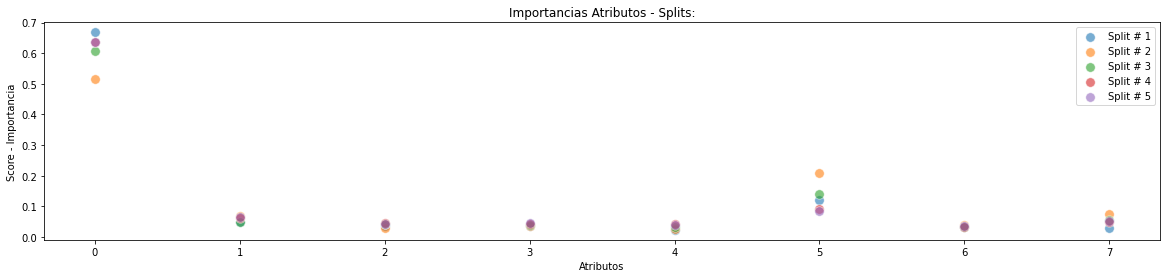

In [47]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = -1)

data_result = ts_cv(X, rf, n_splits=5, figsize=(20,4))



TRAIN # 1: (155,) TEST: (152,)
    --> Error Modelo: RMSE: 4940.549428331047
    --> Error Benchmark - Dia anterior: 8039.626963802814
    --> Diferencia = Modelo - Bench : -3099.077535471767
TRAIN # 2: (307,) TEST: (152,)
    --> Error Modelo: RMSE: 4562.63038398861
    --> Error Benchmark - Dia anterior: 6436.516032107661
    --> Diferencia = Modelo - Bench : -1873.8856481190505
TRAIN # 3: (459,) TEST: (152,)
    --> Error Modelo: RMSE: 5716.778381199803
    --> Error Benchmark - Dia anterior: 6904.859748851948
    --> Diferencia = Modelo - Bench : -1188.0813676521448
TRAIN # 4: (611,) TEST: (152,)
    --> Error Modelo: RMSE: 4835.400522058065
    --> Error Benchmark - Dia anterior: 6459.9680332128255
    --> Diferencia = Modelo - Bench : -1624.5675111547607
TRAIN # 5: (763,) TEST: (152,)
    --> Error Modelo: RMSE: 4683.686103957555
    --> Error Benchmark - Dia anterior: 6239.3188488302485
    --> Diferencia = Modelo - Bench : -1555.6327448726934


 CROSS VALIDATION SCORE: 4947.808

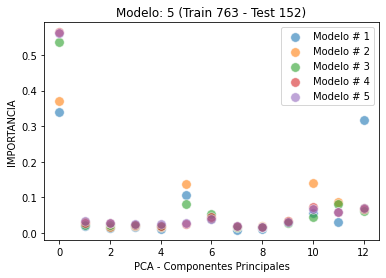

In [188]:
# Armo modelo 

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

# Configuracion
i=0
errores = []
dd = {}
tss = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tss.split(X):
    i+=1
    
    # Defino Kfold de Serie de Tiempo
    print(f"TRAIN # {i}:", train_index.shape, "TEST:", test_index.shape)
    X_train, X_test = X[train_index], X[test_index]    
    y_train, y_test = y[train_index], y[test_index]
    
    # Calibro modelo sobre cada split
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = -1).fit(X_train,y_train)
    
    # Calculo de Benchmark: dia anterior para cada corte
    benchmark =  y[test_index - 1] # un dia menos para todos los indices
    
    # Prediccion y medicion de errores
    y_test_pred = rf.predict(X_test)
    error = np.sqrt(mean_squared_error(y_test, y_test_pred))
    errores.append(error)
    error_benchmark = np.sqrt(mean_squared_error(y_test, benchmark))
    
    # Guardo importancias en Dataframes para explorar
    df=pd.DataFrame({'IMPORTANCIA':rf.feature_importances_ , 'error':error})
    dd[f'split_{i}'] = df
    
    # Grafico Consolidado - Feature importances de cada modelo
    sns.scatterplot(x=np.arange(rf.feature_importances_.size), y=rf.feature_importances_, alpha = 0.6, label=f"Modelo # {i}", s=90)
    plt.title(f"Modelo: {i} (Train {train_index.shape[0]} - Test {test_index.shape[0]})")
    plt.xlabel("PCA - Componentes Principales"); plt.ylabel("IMPORTANCIA")
    
    # Impresion resultados
    print(f"    --> Error Modelo: RMSE: {error}")
    print(f"    --> Error Benchmark - Dia anterior: {error_benchmark}")
    print(f"    --> Diferencia = Modelo - Bench : {error-error_benchmark}")
    
    
cv = np.mean(errores)
print("\n\n", f"CROSS VALIDATION SCORE: {cv}")

#### Resumen y Conclusiones  

En resumen, lo que hicimos fue seleccionar las variables mas importantes, para reducir la carga del modelo y poder agegar algunos atributos y buscar algunas relaciones polinomicas extra, y con eso reentrenar el modelo con los mismos parámetros. El Cross Validation Score de este nuevo modelo RandomForest mejorado resulta de `RMSE: 4947.80` versus el modelo anterior con todas las fechas con un score de `RMSE: 5136.44`. Si bien mejora, no parece haber nuevas interacciones suficientes, polinomiales, que incrementen la precision del modelo, no parece ser un factor muy determinante.

In [158]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,7.837387,0.129607,-0.543283,0.313508,-0.329002,0.394402,-0.419986,0.426060,-0.177087,0.100108,-0.089246,-0.019236,0.118318,-0.096027,0.054230,0.005856,0.043568,0.050775
1,0.971481,-2.839426,-0.478436,0.999255,0.972285,-0.531843,-0.194954,0.024950,-0.049135,0.178932,0.195676,-0.022685,-0.096060,0.072338,0.063544,0.048716,0.033704,0.061159
2,-2.186368,-1.221923,-0.511089,0.255691,0.286378,0.622285,-0.019183,-0.005555,0.036871,-0.395794,0.290861,-0.029027,-0.137186,0.016115,-0.007500,-0.035145,0.003712,0.045072
3,2.801165,2.117268,-1.026703,-0.241781,-0.184465,-0.380103,-0.469044,-0.046050,0.020940,-0.607606,0.158668,-0.193346,-0.082300,-0.116492,-0.002026,0.066140,-0.056605,0.006652
4,0.551222,-0.133148,-2.458912,1.009289,2.240466,-0.189802,0.666437,0.588664,0.093336,-0.267537,-0.136449,-0.013779,-0.029923,-0.013344,0.004432,0.093091,0.035905,-0.114647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,-0.480623,0.923516,0.848043,-1.429399,-1.066620,0.368056,-0.397427,0.417420,-0.186199,0.566043,-0.243339,-0.027564,-0.116479,0.042307,-0.038022,-0.058721,-0.013216,0.001032
911,-2.025799,-0.042327,0.409257,0.562747,0.160638,-0.508991,-0.181994,0.020501,-0.052088,0.535148,0.498487,-0.086571,-0.018938,-0.082960,-0.049532,-0.104565,0.006037,-0.050997
912,-5.396035,1.169829,-0.218049,0.811471,0.425274,0.644767,-0.024691,-0.002030,0.037134,-0.099225,0.526894,-0.054948,0.130820,0.059447,0.109354,-0.137590,-0.003295,-0.024628
913,-3.948887,2.362482,1.265106,-1.148705,0.008113,-0.396813,-0.470285,-0.054302,0.014858,-0.221259,0.006846,-0.176441,0.054482,0.079817,0.139780,0.002689,0.064093,0.062121


#### Prediccion Final

In [160]:
# Split de Test; Elijo los ultimos 92 dias (ultimo trimestre de 2019 sobre matriz X valida)
dias_a_predecir = 92
X_test = X[-dias_a_predecir:] ; y_test = y[-dias_a_predecir:] # inclusivo , dia 92

# Split de Train; fechas anteriores disponibles 
X_train = X[:-dias_a_predecir] ; y_train = y[:-dias_a_predecir] # no inclusivo, dia 92

# Entrenamiento 
rf = RandomForestRegressor(n_estimators = 100, random_state=42, n_jobs = -1)
model = rf.fit(X_train, y_train)

# Prediccion 
y_train_pred = model.predict(X_train)
y_test_pred  = model.predict(X_test)

# Testeo final
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))


In [161]:
print(f"RMSE train: {rmse_train}")
print(f"RMSE test: {rmse_test}")

RMSE train: 1615.3349148500997
RMSE test: 4943.555648299343


In [162]:
# Benchmark dia anterior
y_benchmark = y[-dias_a_predecir-1:-1]
rmse_benchmark = np.sqrt(mean_squared_error(y_test, y_benchmark ))
print(f"RMSE test benchmark: {np.round(rmse_benchmark, 2)}")

RMSE test benchmark: 6944.76


> El resultado final de prediccion contra el ultimo trimestre también mejora gracias al trabajo de variables, pasó de `RMSE: 5106.21` en la version 1 a `RMSE: 4943.56` en la version 2. Sin embargo parece que llegamos a un limite relativamente aceptable de performance en cuanto a este modelo, ya que la mejora no es tan material. 

<u>**Notas:**</u> Quedaria pendiente probar si realizando las relaciones polinomiales sobre el dataset origninal sin filtrar atributos, y luego la realizacion del PCA se descubren algunas relaciones no lineales, interesantes que puedan mejorar el modelo. La dificultad de ese aproach radica en que el volumen de observaciones (fechas pasadas) y un orden de polinomio de n=4 provocaria miles de nuevos atributos y lo cual lo harian un poco inmanejable para un lookback de 180 observaciones pasadas. 

## PENDIENTES

* FUNCION DE CV-TIME SERIES PARA RANDOM FOREST TSCV(N_estimators,k_folds)
* DEBERIA METER DUMMIES EN PCA ?
* JUSTIICACION DE PARTE II FINAL - PROPHET

______________________________________________________________
### 1.Formula una nueva pregunta, problema o desafío para explorar.

### 2.Prueba un modelo de Machine Learning nuevo

### 3.Agrega al proyecto información de otra fuente. 
______________________________________________________________

<br>

### 4. Introduccion y desarrollo de modelos anteriores con PROPHET  

#### 4.1 Introduccion a `Prophet`:  

Prophet es una libreria open-source desarrollada por Facebook, diseñada para desarrollar predicciones y pronósticos sobre Series de Tiempo univariadas o multivariadas (pudiendo agregar nuevos atributos regresores) con el objetivo de lograr predicciones funcionales y precisas de una manera mucho mas escalable y productiva,  facilitando mucho la tarea del proceso de modelado. Escencialmente realiza la eleccion teorica del modelo de manera automática, el ajuste de configuraciones e hiperparámetros, y contiene herramientas y configuraciones para poder ajustar el modelado y realizar tareas como validacion y comparación de resultados y cross validation, tareas que normalmente, y como vimos anteriormente, se realizarían manualmente.

`Prophet` nos permite realizar la misma descomposicion de `modelos aditivos` con series de tiempo de la 3° entrega, permitiendo el mismo analisis original realizado con `StatsModels` de tipo aditivo, para luego analizar los resultantes y también poder realizar pronósticos a futuro con el mismo. Permite la incorporación e identificación de `Tendencia`, y de `Estacionalidad` al modelo, pero también la posibilidad de incorporar regresores extra, como en nuestra lista de mejoras los `Feriados` a sus analisis; con lo cual resulta plenamente compatible con nuestros objetivos de productivización para lograr un modelado de Series de Tiempo mas escalable y productivo.

> _Extracto: "Los ingenieros de Facebook desarrollaron Prophet sobre un backend de STAN, un lenguaje de programación probabilística. Esto le permite hacerse de muchas de las ventajas que ofrece un marco teorico como la estadística Bayesiana de manera mucho mas natural; como la incorporación de estacionalidad, conocimiento específico del ambito de aplicación (problema) y cálculos moviles de intervalos de confianza para una estimación de riesgo basada en datos"_  [Greg Rafferty, 2019 - Forecasting with Facebook Prophet](https://towardsdatascience.com/forecasting-in-python-with-facebook-prophet-29810eb57e66)

<br> 

#### 4.2 Instalacion de Prophet con Anaconda
<U>*Atención:*</U> _Para poder seguir ejecutando el notebook es 100% necesario instalar apropiadamente `fbprophet`. Esta libreria tiene muchas dependencias y complicaciones a la hora de instalarse, por lo que recomendamos 100% usar Anaconda (y su manejo de dependencias) tal como sugiere [Facebook en su documentacion de instalación](https://facebook.github.io/prophet/docs/installation.html), por lo cual sea naecesario cerrar Jupyter para realizazr la instalacion. Usando Conda como instalador, con los siguientes comandos `conda install gcc`, (si arroja error proseguir), y `conda install -c conda-forge fbprophet` para instalarla desde el repositorio conda-forge._

In [19]:
# COMANDOS DE INSTALACIÓN via ANACONDA PROMPT
# conda install gcc
# conda install -c conda-forge fbprophet

#### 4.3 Implementacion de Modelo Básico

Prophet permite argumentos que ayudan a configurar el modelo para poder ajustar el modelado al problema que se necesite, incluyendo la posibilidad de incorporar variabels para introducir conocimiento específico sobre el problema y realizar predicciones personalizadas. Permite configurar el tipo de crecimiento _(growth)_ del modelo, el tipo de estacionalidad que se le requiere _(seasonality)_ y más parametros a mano. Sin embargo, inicialmente el modelo intenta ajustar y optimizar todo de manera automática, con los encontrando los mejores parametros posibles para la prediccion. 

La libreria sigue el paradigma de `Sklearn` con un metodo de `.fit()` para realizar el ajuste y uno de `.predict()` para poder realizar la prediccion. 

Para usarlo, es necesario un `DataFrame` que contenga una columna llamada `ds` con la informacion temporal (en formato date-time) y una columna `y` que contenga la informacion objetivo a predecir, las observaciones. Por eso mismo realizaremos una copia y transformaciones, para crear y disponer de este dataframe:

In [20]:
# Dataframe vacio
df = pd.DataFrame()
# Variable objetivo
df['y'] = dataset.cantidad_pasos
# Serie de tiempo
df['ds'] = dataset.index.values
# Regresores de feriado
df['fl_feriado'] = dataset.fl_feriado

for elem in [x for x in dataset.columns if x.startswith("dia")]:
    df[elem] = dataset[elem].values
    
dias_a_predecir = 92 # misma cantidad de periodos que en TP3
base = df[:-92] # Trunco últimos 92 dias para predecir ['2019-10-01':'2019-12-31']
base[['y','ds']].tail()

,y,ds
fecha,,
2019-09-26,43110.0,2019-09-26
2019-09-27,44985.0,2019-09-27
2019-09-28,41925.0,2019-09-28
2019-09-29,38348.0,2019-09-29
2019-09-30,37170.0,2019-09-30


Con esta estructura basica planteada podemos ya salir adelante y plantear nuestro primer modelo.

#### Primer modelo Básico - Input a la libreria:  
Para eso primero cargamos la libreria, es necesario tenerla correctamente instalada, y luego ajustamos con `fit()` un modelo automático, en default, en Prophet sin ningún tipo de parámetro ni trabajo extra:

In [21]:
# Carga de libreria 
import fbprophet
from fbprophet.plot import add_changepoints_to_plot

In [22]:
# Ajusto modelo en default
prophet = fbprophet.Prophet()
prophet.fit(base)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Luego podemos realizar la prediccion de manera adecuada sobre un dataframe vacío con las fechas:

In [23]:
# Realizo prediccion a futuro
futuro = prophet.make_future_dataframe(periods=92)
pronostico = prophet.predict(futuro)

##### Funcionamiento: 
Prophet elije, en default de manera automática, un modelo de mejor ajuste a las observaciones y parámetros que le pasamos. Para poder generar la prediccion debemos crear un Dataframe con las fechas a predecir, y tiene la funcion `make_future_dataframe` ya está preparada para esto y asi tener una columna de fechas, vacías, formato `datetime`, que darle como argumento al `predict()`.

La prediccion realizada nos devolvió el grafico anterior en donde tenemos los siguientes componentes:

> ###### **RESULTADOS Y COMPONENTES PREDICCION**: 
1. Los puntos negros representan cada observacion individual de la serie original.
1. La linea azul es el pronóstico estimado para toda la serie (posterior al ajuste, se estima para todo el tramo completo)
1. La zona celeste, que la rodea, representa los intervalos de confianza, por default al 95%, de manera de inrorporar una medida del riesgo al pronóstico mismo.
1. Finalmente, la linea roja que atraviesa al pronóstico, es la tendencia posterior a la descomposición, definida con una cantidad `n` de grados de libertad configurable vía parámetros.

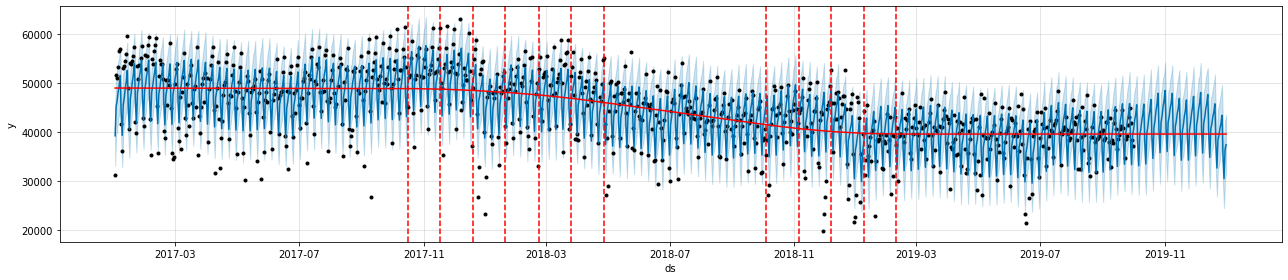

In [24]:
# Ploteo resultados 
fig = prophet.plot(pronostico, figsize=(18,4))
a = add_changepoints_to_plot(fig.gca(), prophet, pronostico)

In [25]:
from sklearn.metrics import mean_squared_error
import numpy as np

y_pred = pronostico.yhat[-92:]
y = dataset.cantidad_pasos[-92:]
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"Prophet - Modelo #1: {rmse}")

Prophet - Modelo #1: 5985.1327250286895


##### Resultados- Error e Interpretación - Primer modelo Básico:  

* Modelo TP3 (Random Forest): `RMSE =  5,106.20`
* Prophet #1 Modelo: `RMSE: 5,932.17`

Para un primer modelo, extremadamente rapido obtenemos un valor primario de `RMSE: 5,932.17` lo cual, teniendo en cuenta que nuestro modelo de RandomForest original logró un `RMSE: 5,106.20` no es muy bueno, sin embargo hay que entender que el modelo fue realizado de manera completamente automática, sin ningún trabajo de variables extra, ni ninguna configuración adicional al lanzarlo. La facilidad inicial con la cual fue hecho es de considerar.

Por otro lado, si vemos los intervalos de confianza, vemos que la prediccion cubre la mayor parte de las observaciones, en terminos generales, dentro de los mismos. 

Sin embargo, sigue siendo un modelo default básico. Hay mucho espacio para la mejora sabiendo que tenemos que agregar la informacion de los feriados, probablmente clasificados como 'outliers' por el modelo automático, junto con la info del tipo de día.

En el siguiente grafico obtenemos, de manera facil, la descomposición en `Tendencia`, `Estacionalidades`, y `Ruido`  sumado a los regresores extra que agreguemos. Esto nos permite un factor extra de interpretabilidad, en comparacion con la opcion manual de Random forest anterior, muy parecido a la opcion obtenida con `statsmodels`. Es parte de las ventajas de operar con modelos de series de tiempo teoricos puros, que pueden ajustar el modelo a estos parametros teóricos. Esta descomposición nos permite identificar comportamientos importantes para poder responder preguntas y cuestiones de negocio:


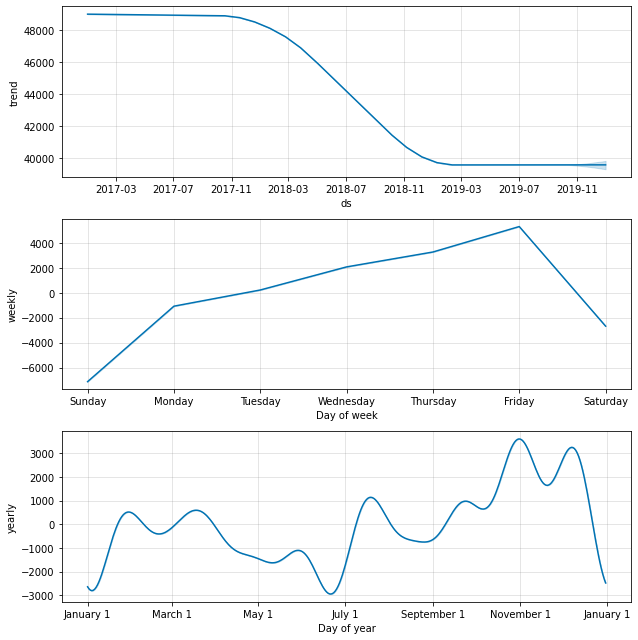

In [26]:
descomp = prophet.plot_components(pronostico, uncertainty=True)

Podemos ver la configuracion de los ajustes encontrados para los componentes del modelo, asi:

In [27]:
prophet.seasonalities

OrderedDict([('yearly',
              {'period': 365.25,
               'fourier_order': 10,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None}),
             ('weekly',
              {'period': 7,
               'fourier_order': 3,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None})])

Prophet, encontró y ajustó una estacionalidad Anual y Semanal. Esto puede variar en funcion de cada serie y la configuracion que otorgue mejor ajuste, encontrada por Prophet.  

**<u>Composición:</u>** En el grafico, se pueden ver sus aportes por separado:  

- Grafico #1: Tendencia - Movimiento general resultante para toda la serie, neto de las estacionalidades encontradas
- Grafico #2: Estacionalidad Semanal - Movimiento ciclico intra-semanal y su impacto
- Grafico #3: Estacionalidad Anual - Movimiento ciclico intra-anual, y su impacto

La configuracion de la estacionalidad es editable, y es una de las configuraciones manuales e hiperparámetros a tener en cuenta al momento de usar la libreria.

#### 4.4 Modificaciones y Mejoras  
A partir de la configuracion básica, podemos seguir configurando el modelo y ajustarlo. Agregaremos informacion del dominio de aplicacion, los feriados, y todas las mejoras que hablamos anteriormente, tambien con esta libreria para ver su equivalencia.  

Finalmente, podriamos tunear algunos hiperparametros con Validacion Cruzada usando `TimeSeriesCrossValidation` de `sklearn`. Prophet incorpora herramental para realizar controles de performance, cross validation y seleccion de modelos, y ya contiene una funcion llamada `cross_validation` pero no la utilizaremos ya que necesitamos compatibildiad con el trabajo anterior [\[Paper - Prophet - Forecasting at scale\]](https://peerj.com/preprints/3190.pdf)

In [28]:
df.tail()

,y,ds,fl_feriado,dia_0,dia_1,dia_2,dia_3,dia_4,dia_5,dia_6
fecha,,,,,,,,,,
2019-12-27,40182.0,2019-12-27,0,0,0,0,0,1,0,0
2019-12-28,30681.0,2019-12-28,0,0,0,0,0,0,1,0
2019-12-29,26259.0,2019-12-29,0,0,0,0,0,0,0,1
2019-12-30,34523.0,2019-12-30,0,1,0,0,0,0,0,0
2019-12-31,21447.0,2019-12-31,0,0,1,0,0,0,0,0


#### Valores a Predecir  
Necesito agregar al modelo y luego entregarle todos los valores de regresores utilizados para poder predecir:

In [29]:
futuro_2 = df.drop(columns='y')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


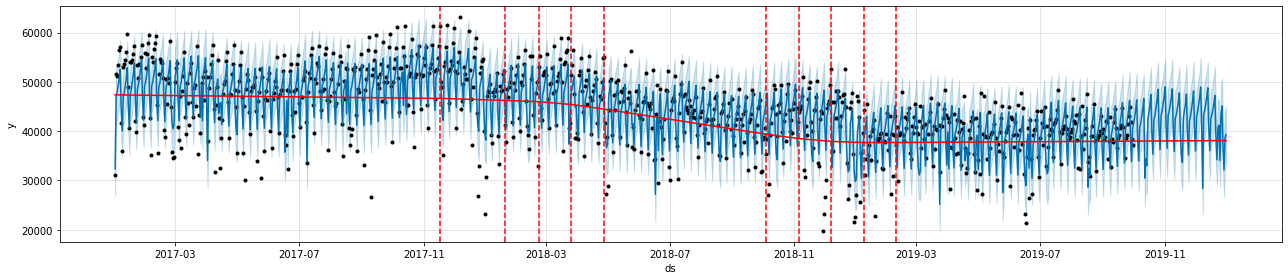

In [30]:
prophet = fbprophet.Prophet()
prophet.add_regressor('fl_feriado')
prophet.add_regressor('dia_0')
prophet.add_regressor('dia_1')
prophet.add_regressor('dia_2')
prophet.add_regressor('dia_3')
prophet.add_regressor('dia_4')
prophet.add_regressor('dia_5')
prophet.add_regressor('dia_6')
prophet.fit(base)

# Realizo prediccion a futuro
# futuro = prophet.make_future_dataframe(periods=92)
pronostico = prophet.predict(futuro_2)
# Ploteo resutlados 
fig = prophet.plot(pronostico, figsize=(18,4))
a = add_changepoints_to_plot(fig.gca(), prophet, pronostico)

##### RESULTADOS - Adicion de nuevos atributos regresores: 

In [32]:
y_pred = pronostico.yhat[-92:]
y = dataset.cantidad_pasos[-92:]
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"Prophet - Modelo #2 - RMSE: {rmse}")

Prophet - Modelo #2 - RMSE: 6281.238608079616


Como podemos ver, el error baja pero todavia no se acerca a valores del modelo final de RandomForest. Esto es entendible, ya que a pesar que le agregamos informacion valida de `feriados` contra la cual realizar una regresion, la info correspondiente al dia en cuestion, antes necesaria en nuestra version casera de modelo de serie de tiempo con RandomForest, en esta caso no es necesaria, ya que Prophet ya identifica, por la fecha, el componente estacional Intra-semanal (como vimos en la primera descomposición). 

Veamos sin embargo el nuevo resultante de la descomposición:


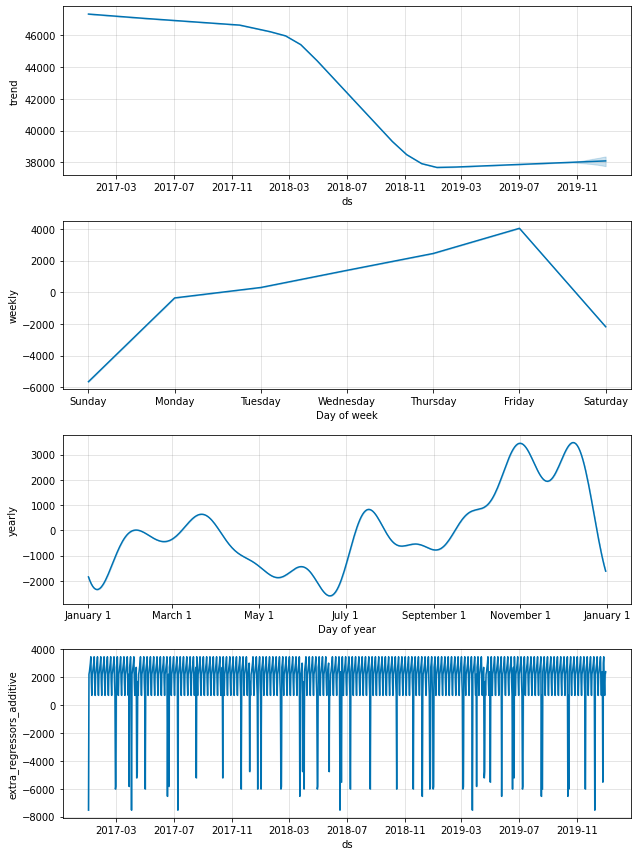

In [155]:
descomp2 = prophet.plot_components(pronostico, uncertainty=True)

En el ultimo grafico `Extra_regressors_additive` vemos la suma de todos los efectos de regresores extra (efecto de `Feriados`+ `Dia_semana`). Por esto mismose ven caidas pronunciadas del orden de los `-6,000 viajes diarios` efecto atribuido por nuestro propio conocimiento a los feriados, mientras que por otro lado vemos una fluctuación repetitiva, de orden estacional, por el efecto de los dias de semana `Dia_semana`, el cual es una fluctuacion estacional, visualizada a nivel de serie completa.  

Al mismo tiempo, vemos que el modelo funciona prediciendo ciclos apropiadamente, pero tiene cierto grado de error ante comportamientos erraticos que no logra identificar, tal vez cierta insensibilidiad a atributos que no ha identificado y le hacen errar en sus predicciones, en menor medida. Visualizacion de los ultimos 92 dias a predecir y serie original:

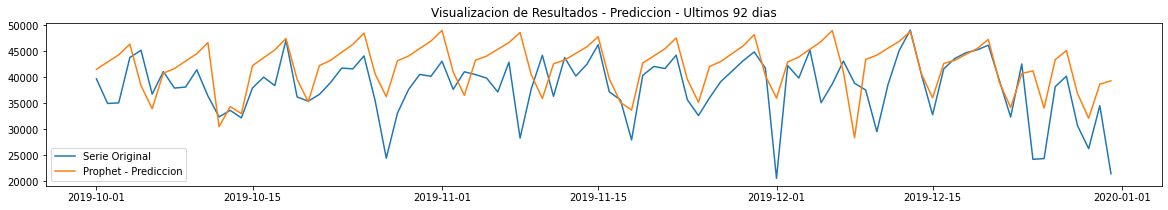

In [46]:
plt.figure(figsize=(20,3))
plt.plot(y.index, y.values, label="Serie Original")
plt.plot(y.index, y_pred, label = "Prophet - Prediccion")
plt.legend()
plt.title("Visualizacion de Resultados - Prediccion - Ultimos 92 dias");

Si bien la serie parece errática en ciertas fechas no encontramos ningún tipo de paro de transporte ni variable exógena extra que pudiera explicar semejantes caidas e ingestar al modelo, por lo que en principio lo atribuiremos a la normalidad y a que el modelo no logra detectar todas las sutilezas posibles a nivel interno. En particular pareciera haber una sobreestimacion de los dias de mitad de semana, en particular martes y miercoles en ciertos puntos.

In [81]:
df.index

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='fecha', length=1095, freq='D')

In [171]:
# Python
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}


In [179]:
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]


In [172]:
itertools.product(*param_grid.values())

In [180]:
all_params

[{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01},
 {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1},
 {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0},
 {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0},
 {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01},
 {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1},
 {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0},
 {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0},
 {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01},
 {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1},
 {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0},
 {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0},
 {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01},
 {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1},
 {'changepoint_prior_scale': 0.5, 'seasonal

___________________

In [106]:
prophet = fbprophet.Prophet()

prophet.add_regressor('fl_feriado')
# prophet.add_regressor('dia_0')
# prophet.add_regressor('dia_1')
# prophet.add_regressor('dia_2')
# prophet.add_regressor('dia_3')
# prophet.add_regressor('dia_4')
# prophet.add_regressor('dia_5')
# prophet.add_regressor('dia_6')

    

def cross_validate_prophet(df, proph_obj, n_splits=5):
    from sklearn.model_selection import TimeSeriesSplit
    from sklearn.metrics import mean_squared_error

    tss = TimeSeriesSplit(n_splits=n_splits)

    # Configuracion
    i=0 # index
    err_test = list()
    err_train = list()
    dd = dict()


    for ix, train_index, test_index in enumerate(tss.split(df)):
        X_train = df[train_index[0]:train_index[-1]+1]
        X_test = df[test_index[0]:test_index[-1]+1]

        y_train = df[train_index[0]:train_index[-1]+1].loc[:,'y']
        y_test = df[test_index[0]:test_index[-1]+1].loc[:,'y']


        dd[f'model_{ix}'] = proph_obj.fit(X_train)
        dd["y_pred_"+str(ix)+"_train"] = y_pred_train = proph_obj.predict(X_train)
        dd["y_pred_"+str(ix)+"_test"] = y_pred_test = proph_obj.predict(X_test)
        dd['err_'+str(ix)+"_train"] = y_train - y_pred_train.yhat # diferencial
        dd['err_'+str(ix)+"_test"] = y_test - y_pred_test.yhat
        dd[f'RMSE_train_{str(ix)}'] = RMSE_train = np.sqrt(mean_squared_error(y_train, y_pred_train.yhat))
        dd[f'RMSE_test_{str(ix)}'] = RMSE_test = np.sqrt(mean_squared_error(y_test, y_pred_test.yhat))
        print(f"Split {ix}: RMSE_train: {RMSE_train} RMSE_test: {RMSE_test}")

        err_train = err_test.append(RMSE_test)
        err_test = err_test.append(RMSE_test)

# # Ploteo resutlados 
# fig = prophet.plot(pronostico, figsize=(18,4))
# a = add_changepoints_to_plot(fig.gca(), prophet, pronostico)

In [183]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error



tss = TimeSeriesSplit(n_splits=4)

# Configuracion
i=0 # index
err_test = []
err_train = []
dd = dict()


for train_index, test_index in tss.split(df):
    prophet = fbprophet.Prophet(yearly_seasonality=True)
    prophet.add_regressor('fl_feriado')
    
    
    i+=1
    X_train = df[train_index[0]:train_index[-1]+1]
    X_test = df[test_index[0]:test_index[-1]+1]

    y_train = df[train_index[0]:train_index[-1]+1].loc[:,'y']
    y_test = df[test_index[0]:test_index[-1]+1].loc[:,'y']


    dd[f'model_{i}'] = prophet.fit(X_train)
    dd["y_pred_"+str(i)+"_train"] = y_pred_train = prophet.predict(X_train)
    dd["y_pred_"+str(i)+"_test"] = y_pred_test = prophet.predict(X_test)
    dd['err_'+str(i)+"_train"] = y_train - y_pred_train.yhat # diferencial
    dd['err_'+str(i)+"_test"] = y_test - y_pred_test.yhat
    dd[f'RMSE_train_{str(i)}'] = RMSE_train = np.sqrt(mean_squared_error(y_train, y_pred_train.yhat))
    dd[f'RMSE_test_{str(i)}'] = RMSE_test = np.sqrt(mean_squared_error(y_test, y_pred_test.yhat))
    print(f"Split {i}: RMSE_train: {RMSE_train} RMSE_test: {RMSE_test}")
    
    border_train = [x.strftime("%d-%m-%Y") for x in df.ds[[train_index[0],train_index[-1]]]]
    border_test = [x.strftime("%d-%m-%Y") for x in df.ds[[test_index[0],test_index[-1]]]]
    print(prophet.seasonalities)
    
    print(f"    Train frontier: {border_train[0]} // {border_train[1]}")
    print(f"    Test frontier: {border_test[0]} // {border_test[1]}")
    
    err_train.append(RMSE_test)
    err_test.append(RMSE_test)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Split 1: RMSE_train: 3589.765248848095 RMSE_test: 18761.014304447435
OrderedDict([('yearly', {'period': 365.25, 'fourier_order': 10, 'prior_scale': 10.0, 'mode': 'additive', 'condition_name': None}), ('weekly', {'period': 7, 'fourier_order': 3, 'prior_scale': 10.0, 'mode': 'additive', 'condition_name': None})])
    Train frontier: 01-01-2017 // 07-08-2017
    Test frontier: 08-08-2017 // 14-03-2018


C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Split 2: RMSE_train: 3619.95197980114 RMSE_test: 11905.218178996625
OrderedDict([('yearly', {'period': 365.25, 'fourier_order': 10, 'prior_scale': 10.0, 'mode': 'additive', 'condition_name': None}), ('weekly', {'period': 7, 'fourier_order': 3, 'prior_scale': 10.0, 'mode': 'additive', 'condition_name': None})])
    Train frontier: 01-01-2017 // 14-03-2018
    Test frontier: 15-03-2018 // 19-10-2018


C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Split 3: RMSE_train: 3678.259524223467 RMSE_test: 10127.545677182216
OrderedDict([('yearly', {'period': 365.25, 'fourier_order': 10, 'prior_scale': 10.0, 'mode': 'additive', 'condition_name': None}), ('weekly', {'period': 7, 'fourier_order': 3, 'prior_scale': 10.0, 'mode': 'additive', 'condition_name': None})])
    Train frontier: 01-01-2017 // 19-10-2018
    Test frontier: 20-10-2018 // 26-05-2019


C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



Split 4: RMSE_train: 4325.264617318587 RMSE_test: 4989.9178227717575
OrderedDict([('yearly', {'period': 365.25, 'fourier_order': 10, 'prior_scale': 10.0, 'mode': 'additive', 'condition_name': None}), ('weekly', {'period': 7, 'fourier_order': 3, 'prior_scale': 10.0, 'mode': 'additive', 'condition_name': None})])
    Train frontier: 01-01-2017 // 26-05-2019
    Test frontier: 27-05-2019 // 31-12-2019


['2019-07-03', '2019-12-31']

__________________
#### TESTEO DE INDEXADO `TIMESERIESSPLIT`

In [160]:
from sklearn.metrics import mean_squared_error

# Configuracion
i=0
errores = []
dd = {}
# plt.figure(figsize=(18,6))

for train_index, test_index in tss.split(df1):
    print("Train index", train_index.shape)
    print("Test index", test_index.shape)
    print("Inicio Train:", train_index[0], "Fin:", train_index[-1])
    print("Inicio Test:", test_index[0], "Fin:", test_index[-1], "\n")
    print("TRAIN")
#     display(df1.iloc[[train_index[0],train_index[-1]],:])
    display(df1.iloc[train_index[0]:train_index[-1]+1,:])
    print("TEST")
#     display(df1.iloc[[test_index[0],test_index[-1]],:])
    display(df1.iloc[test_index[0]:test_index[-1]+1,:])
    print("")
    print("")
    
    print(train_index, "\n", "\n", test_index)
    print("")
    print("")
    
#     print("Train index:", train_index[0], train_index[-1])
#     print("Test index:", test_index[0], test_index[-1])
#     df[:train_index[-1]+1]
    
    

Train index (185,)
Test index (182,)
Inicio Train: 0 Fin: 184
Inicio Test: 185 Fin: 366 

TRAIN


,fecha,y,ds,fl_feriado,dia_0,dia_1,dia_2,dia_3,dia_4,dia_5,dia_6
0,2017-01-01,31183.0,2017-01-01,1,0,0,0,0,0,0,1
1,2017-01-02,51568.0,2017-01-02,0,1,0,0,0,0,0,0
2,2017-01-03,51093.0,2017-01-03,0,0,1,0,0,0,0,0
3,2017-01-04,53332.0,2017-01-04,0,0,0,1,0,0,0,0
4,2017-01-05,56486.0,2017-01-05,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
180,2017-06-30,55433.0,2017-06-30,0,0,0,0,0,1,0,0
181,2017-07-01,45628.0,2017-07-01,0,0,0,0,0,0,1,0
182,2017-07-02,40770.0,2017-07-02,0,0,0,0,0,0,0,1
183,2017-07-03,46961.0,2017-07-03,0,1,0,0,0,0,0,0


TEST


,fecha,y,ds,fl_feriado,dia_0,dia_1,dia_2,dia_3,dia_4,dia_5,dia_6
185,2017-07-05,50344.0,2017-07-05,0,0,0,1,0,0,0,0
186,2017-07-06,51034.0,2017-07-06,0,0,0,0,1,0,0,0
187,2017-07-07,52293.0,2017-07-07,0,0,0,0,0,1,0,0
188,2017-07-08,41944.0,2017-07-08,0,0,0,0,0,0,1,0
189,2017-07-09,33578.0,2017-07-09,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
362,2017-12-29,54556.0,2017-12-29,0,0,0,0,0,1,0,0
363,2017-12-30,39969.0,2017-12-30,0,0,0,0,0,0,1,0
364,2017-12-31,23229.0,2017-12-31,0,0,0,0,0,0,0,1
365,2018-01-01,30735.0,2018-01-01,1,1,0,0,0,0,0,0




[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184] 
 
 [185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238
 239 240 241 242 243 24

,fecha,y,ds,fl_feriado,dia_0,dia_1,dia_2,dia_3,dia_4,dia_5,dia_6
0,2017-01-01,31183.0,2017-01-01,1,0,0,0,0,0,0,1
1,2017-01-02,51568.0,2017-01-02,0,1,0,0,0,0,0,0
2,2017-01-03,51093.0,2017-01-03,0,0,1,0,0,0,0,0
3,2017-01-04,53332.0,2017-01-04,0,0,0,1,0,0,0,0
4,2017-01-05,56486.0,2017-01-05,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
362,2017-12-29,54556.0,2017-12-29,0,0,0,0,0,1,0,0
363,2017-12-30,39969.0,2017-12-30,0,0,0,0,0,0,1,0
364,2017-12-31,23229.0,2017-12-31,0,0,0,0,0,0,0,1
365,2018-01-01,30735.0,2018-01-01,1,1,0,0,0,0,0,0


TEST


,fecha,y,ds,fl_feriado,dia_0,dia_1,dia_2,dia_3,dia_4,dia_5,dia_6
367,2018-01-03,48162.0,2018-01-03,0,0,0,1,0,0,0,0
368,2018-01-04,47953.0,2018-01-04,0,0,0,0,1,0,0,0
369,2018-01-05,49505.0,2018-01-05,0,0,0,0,0,1,0,0
370,2018-01-06,39235.0,2018-01-06,0,0,0,0,0,0,1,0
371,2018-01-07,37522.0,2018-01-07,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
544,2018-06-29,52230.0,2018-06-29,0,0,0,0,0,1,0,0
545,2018-06-30,32740.0,2018-06-30,0,0,0,0,0,0,1,0
546,2018-07-01,30004.0,2018-07-01,0,0,0,0,0,0,0,1
547,2018-07-02,44289.0,2018-07-02,0,1,0,0,0,0,0,0




[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 

,fecha,y,ds,fl_feriado,dia_0,dia_1,dia_2,dia_3,dia_4,dia_5,dia_6
0,2017-01-01,31183.0,2017-01-01,1,0,0,0,0,0,0,1
1,2017-01-02,51568.0,2017-01-02,0,1,0,0,0,0,0,0
2,2017-01-03,51093.0,2017-01-03,0,0,1,0,0,0,0,0
3,2017-01-04,53332.0,2017-01-04,0,0,0,1,0,0,0,0
4,2017-01-05,56486.0,2017-01-05,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
544,2018-06-29,52230.0,2018-06-29,0,0,0,0,0,1,0,0
545,2018-06-30,32740.0,2018-06-30,0,0,0,0,0,0,1,0
546,2018-07-01,30004.0,2018-07-01,0,0,0,0,0,0,0,1
547,2018-07-02,44289.0,2018-07-02,0,1,0,0,0,0,0,0


TEST


,fecha,y,ds,fl_feriado,dia_0,dia_1,dia_2,dia_3,dia_4,dia_5,dia_6
549,2018-07-04,46669.0,2018-07-04,0,0,0,1,0,0,0,0
550,2018-07-05,46014.0,2018-07-05,0,0,0,0,1,0,0,0
551,2018-07-06,51226.0,2018-07-06,0,0,0,0,0,1,0,0
552,2018-07-07,38678.0,2018-07-07,0,0,0,0,0,0,1,0
553,2018-07-08,37028.0,2018-07-08,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
726,2018-12-28,47832.0,2018-12-28,0,0,0,0,0,1,0,0
727,2018-12-29,35446.0,2018-12-29,0,0,0,0,0,0,1,0
728,2018-12-30,21559.0,2018-12-30,0,0,0,0,0,0,0,1
729,2018-12-31,22599.0,2018-12-31,1,1,0,0,0,0,0,0




[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 

,fecha,y,ds,fl_feriado,dia_0,dia_1,dia_2,dia_3,dia_4,dia_5,dia_6
0,2017-01-01,31183.0,2017-01-01,1,0,0,0,0,0,0,1
1,2017-01-02,51568.0,2017-01-02,0,1,0,0,0,0,0,0
2,2017-01-03,51093.0,2017-01-03,0,0,1,0,0,0,0,0
3,2017-01-04,53332.0,2017-01-04,0,0,0,1,0,0,0,0
4,2017-01-05,56486.0,2017-01-05,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
726,2018-12-28,47832.0,2018-12-28,0,0,0,0,0,1,0,0
727,2018-12-29,35446.0,2018-12-29,0,0,0,0,0,0,1,0
728,2018-12-30,21559.0,2018-12-30,0,0,0,0,0,0,0,1
729,2018-12-31,22599.0,2018-12-31,1,1,0,0,0,0,0,0


TEST


,fecha,y,ds,fl_feriado,dia_0,dia_1,dia_2,dia_3,dia_4,dia_5,dia_6
731,2019-01-02,47080.0,2019-01-02,0,0,0,1,0,0,0,0
732,2019-01-03,46194.0,2019-01-03,0,0,0,0,1,0,0,0
733,2019-01-04,42887.0,2019-01-04,0,0,0,0,0,1,0,0
734,2019-01-05,25650.0,2019-01-05,0,0,0,0,0,0,1,0
735,2019-01-06,35546.0,2019-01-06,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
908,2019-06-28,44179.0,2019-06-28,0,0,0,0,0,1,0,0
909,2019-06-29,34754.0,2019-06-29,0,0,0,0,0,0,1,0
910,2019-06-30,30793.0,2019-06-30,0,0,0,0,0,0,0,1
911,2019-07-01,38705.0,2019-07-01,0,1,0,0,0,0,0,0




[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 

,fecha,y,ds,fl_feriado,dia_0,dia_1,dia_2,dia_3,dia_4,dia_5,dia_6
0,2017-01-01,31183.0,2017-01-01,1,0,0,0,0,0,0,1
1,2017-01-02,51568.0,2017-01-02,0,1,0,0,0,0,0,0
2,2017-01-03,51093.0,2017-01-03,0,0,1,0,0,0,0,0
3,2017-01-04,53332.0,2017-01-04,0,0,0,1,0,0,0,0
4,2017-01-05,56486.0,2017-01-05,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
908,2019-06-28,44179.0,2019-06-28,0,0,0,0,0,1,0,0
909,2019-06-29,34754.0,2019-06-29,0,0,0,0,0,0,1,0
910,2019-06-30,30793.0,2019-06-30,0,0,0,0,0,0,0,1
911,2019-07-01,38705.0,2019-07-01,0,1,0,0,0,0,0,0


TEST


,fecha,y,ds,fl_feriado,dia_0,dia_1,dia_2,dia_3,dia_4,dia_5,dia_6
913,2019-07-03,41613.0,2019-07-03,0,0,0,1,0,0,0,0
914,2019-07-04,37124.0,2019-07-04,0,0,0,0,1,0,0,0
915,2019-07-05,40815.0,2019-07-05,0,0,0,0,0,1,0,0
916,2019-07-06,44932.0,2019-07-06,0,0,0,0,0,0,1,0
917,2019-07-07,32975.0,2019-07-07,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1090,2019-12-27,40182.0,2019-12-27,0,0,0,0,0,1,0,0
1091,2019-12-28,30681.0,2019-12-28,0,0,0,0,0,0,1,0
1092,2019-12-29,26259.0,2019-12-29,0,0,0,0,0,0,0,1
1093,2019-12-30,34523.0,2019-12-30,0,1,0,0,0,0,0,0




[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 

In [161]:
df1[:367].shape

(367, 11)

In [162]:
df1.iloc[train_index[0]:train_index[-1],:]

,fecha,y,ds,fl_feriado,dia_0,dia_1,dia_2,dia_3,dia_4,dia_5,dia_6
0,2017-01-01,31183.0,2017-01-01,1,0,0,0,0,0,0,1
1,2017-01-02,51568.0,2017-01-02,0,1,0,0,0,0,0,0
2,2017-01-03,51093.0,2017-01-03,0,0,1,0,0,0,0,0
3,2017-01-04,53332.0,2017-01-04,0,0,0,1,0,0,0,0
4,2017-01-05,56486.0,2017-01-05,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
907,2019-06-27,42227.0,2019-06-27,0,0,0,0,1,0,0,0
908,2019-06-28,44179.0,2019-06-28,0,0,0,0,0,1,0,0
909,2019-06-29,34754.0,2019-06-29,0,0,0,0,0,0,1,0
910,2019-06-30,30793.0,2019-06-30,0,0,0,0,0,0,0,1


In [163]:
df[185:]

,y,ds,fl_feriado,dia_0,dia_1,dia_2,dia_3,dia_4,dia_5,dia_6
fecha,,,,,,,,,,
2017-07-05,50344.0,2017-07-05,0,0,0,1,0,0,0,0
2017-07-06,51034.0,2017-07-06,0,0,0,0,1,0,0,0
2017-07-07,52293.0,2017-07-07,0,0,0,0,0,1,0,0
2017-07-08,41944.0,2017-07-08,0,0,0,0,0,0,1,0
2017-07-09,33578.0,2017-07-09,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2019-12-27,40182.0,2019-12-27,0,0,0,0,0,1,0,0
2019-12-28,30681.0,2019-12-28,0,0,0,0,0,0,1,0
2019-12-29,26259.0,2019-12-29,0,0,0,0,0,0,0,1


**LISTADO DE PENDIENTES :**  
- [X] 21/02 Lectura de Matplotlib
- [X] 21/02 Modificacion de graficos Prophet
- [X] 22/02 Interpolar Nulos
- [ ] 24/02 Time Series split para hiperparametros

In [164]:
# prophet = Prophet(holidays=promo)
# prophet.add_country_holidays(country_name='US')
# prophet.fit(df)

# future = prophet.make_future_dataframe(periods=365, freq='D')
# forecast = prophet.predict(future)
# fig = prophet.plot(forecast)
# a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
# plt.show()
# fig2 = prophet.plot_components(forecast)
# plt.show()

### 4. PROPHET LINKS

#### ARTICULOS INSTRUCTIVOS    
1. [Instructivo basico Series Tiempo- Prophet](https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/)
1. [Instructivo Detallado - Series de tiempo  - Prophet](https://towardsdatascience.com/facebook-prophet-for-time-series-forecasting-in-python-part1-d9739cc79b1d)
1. [Analitica - Publicidad de instagram - Python Prophet](https://towardsdatascience.com/forecasting-in-python-with-facebook-prophet-29810eb57e66)

#### MODELOS TEORIA
1. [Time Series Forecasting](https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/)

#### TEORICO/PROGRAMACION
1. [Documentacion - Intro Quickstart](https://facebook.github.io/prophet/docs/quick_start.html)
1. [Prophet Paper presentation - official \[filetype:pdf\]](https://peerj.com/preprints/3190.pdf)
1. [Documentacion - Agregado de Regresores (Variables)](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#additional-regressors)

#### DELICIOSO PARA LEER (Personal)
1. [Multidimensional Time Series With Stumpy](https://towardsdatascience.com/part-10-discovering-multidimensional-time-series-motifs-45da53b594bb)
1. [Articulo - Unfair Machine learning advantage](https://towardsdatascience.com/machine-learning-is-a-zero-sum-game-7498614c9ac3)
1. [PDF text extraction](https://towardsdatascience.com/how-to-extract-the-text-from-pdfs-using-python-and-the-google-cloud-vision-api-7a0a798adc13)
1. [EXcel vs Python - HOw to do common operations](https://towardsdatascience.com/excel-vs-python-how-to-do-common-data-analysis-tasks-54f1bdd6dfaa)

### Pruebas

##### Indexado reverso

In [165]:
dataset.cantidad_pasos.index[:8]

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08'],
              dtype='datetime64[ns]', name='fecha', freq='D')